# Explaining Linear Models

This tutorial will discuss **Linear Models** and how they provide built-in explanations to their decisions. 
Although Linear Models tend to perform worse than other models, it is important to understand how to interpret them. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
np.random.seed(42)

## Linear Models
### Definition
A Linear Model takes the following form

$$h(x) = \omega_0 + \sum_{j=1}^d \omega_j x_j,$$

where $\omega_0$ is called the bias and $\omega_j$ are called the weights. These models are advertised as highly-interpretable for two reasons.

1. The effect of increasing $x_i$ in the output $h(x)$ is the same regardless of the other features $(x_1,\ldots, x_{i-1}, x_{i+1}, \ldots, x_d)$. This allows the practitioner to study the effect of varying a feature $x_i$ without needing to know the value of the $d-1$ others.
2. Increasing $x_i$ by $1$ increases the output by $\omega_i$. If $\omega_i$ is negative, the output actually decreases. Thus, the effect of varying $x_i$ is simple to conceptualize.

### Toy Example

In [2]:
from pyfd.features import Features

# Setup data and model
X = np.random.uniform(1, 2, size=(100, 1))
features = Features(X, ["x"], ["num"])
x_explain = np.array([1.1])
y = 2 - X.ravel() + 0.1 * np.random.normal(size=(100,))
model = LinearRegression().fit(X, y)

Text(0, 0.5, 'y')

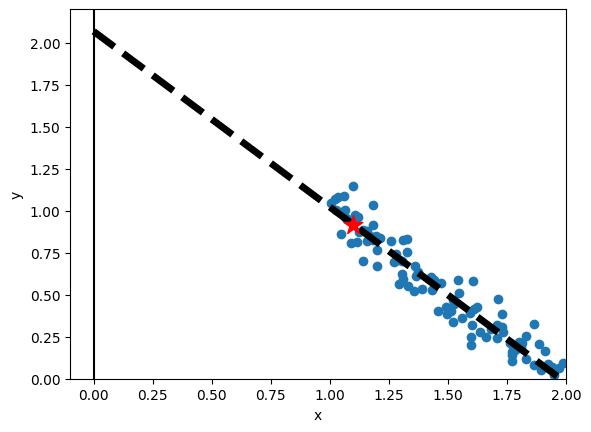

In [3]:
# Plot the data and Linear Model
plt.figure()
plt.scatter(X.ravel(), y)
plt.vlines(0, 0, 2.2, 'k')
line = np.linspace(0, 2, 10)
plt.plot(line, model.intercept_ + model.coef_[0]*line, 'k--', linewidth=5)
plt.scatter(x_explain, model.intercept_ + model.coef_[0]*x_explain, marker="*", c='r', s=200, zorder=3)
plt.xlim(-0.1, 2)
plt.ylim(0, 2.2)
plt.xlabel("x")
plt.ylabel("y")

We want to understand the prediction at a point $x_\text{explain}=1.1$ (indicated by a red star).
It is tempting to interpret the value $\omega \,x_\text{explain}$ as the importance of the feature
$x_\text{explain}$ for the prediction. This yields

In [4]:
print(f"Local Attribution of x_explain : {float(model.coef_[0]*x_explain[0]):.2f}")

Local Attribution of x_explain : -1.15


 But if we center the dataset, then we get an explanation with a completely different sign!

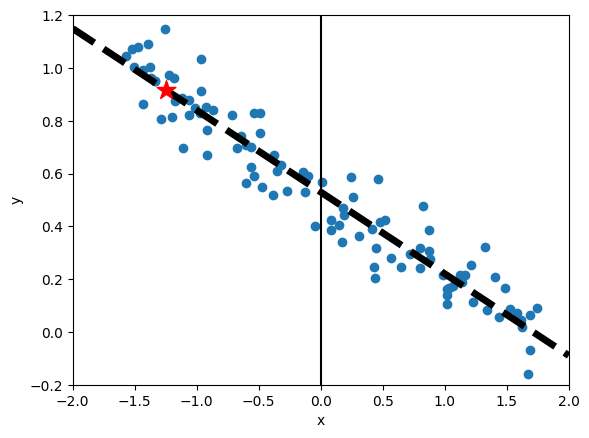

Local Attribution of x_explain_ : 0.39


In [5]:
X_mean = X.mean(0)
X_std = X.std(0)
# Centered data X_
X_ = (X - X_mean) / X_std
# Samr datum but centered
x_explain_ = (x_explain - X_mean) / X_std
model_ = LinearRegression().fit(X_, y)

plt.figure()
plt.scatter(X_.ravel(), y)
plt.vlines(0, -2, 2, 'k')
line = np.linspace(-2, 2, 10)
plt.plot(line, model_.intercept_ + model_.coef_[0]*line, 'k--', linewidth=5)
plt.scatter(x_explain_, model_.intercept_ + model_.coef_[0]*x_explain_, marker="*", c='r', s=200, zorder=3)
plt.xlim(-2, 2)
plt.ylim(-0.2, 1.2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f"Local Attribution of x_explain_ : {float(model_.coef_[0]*x_explain_[0]):.2f}")

What is happening here? The issue is that the importance $\omega x_\text{explain}$ is not
**invariant** to affine mappings of the feature. Lets say $x$ encodes a temperature.
Changing its units from Celcius to Fahreinheit will change the feature's importance although the 
model prediction stays intact.To solve this problem, we must not think of local importance in absolute terms but
in **relative** terms. Instead of presenting the impact of $x$ on a specific prediction $h(x)$, we investigate the impact of $x$ on the Gap

$$ G(h, x, \mathcal{B}) = h(x) - \mathbb{E}_{z\sim\mathcal{B}}[h(z)],$$

which is the difference between $h(x)$ and a baseline prediction $\mathbb{E}_{z\sim\mathcal{B}}[h(z)]$.
The probability distribution $\mathcal{B}$ is called the *background*. Thus, explanining a prediction actually
amounts to measuring a large Gap $G(h, x, \mathcal{B})\neq 0$ and wondering which features cause this Gap to be large. Here are examples of Gaps we might want to explain:

1. Why is individual $x$ predicted to have higher-than-average risk of heart disease? Here, the Gap is positive
and the background $\mathcal{B}$ is the distribution over the whole dataset.
2. Why is house $x$ predicted to have a lower price than house $z$? In that case, the Gap is negative and the background $\mathcal{B}$ is the dirac measure $\delta_z$.

The natural local feature importance to explain a Gap is the following.

$$\text{Local Importance of $x_i$} = \omega_i\, (x_i-\mathbb{E}_{z\sim\mathcal{B}}[z_i]),$$

which sum up to the Gap

$$ \sum_{i=1}^d \text{Local Importance of $x_i$} = G(h, x, \mathcal{B}).$$

Beyond summing to the Gap, these feature importance metrics have the property of being **invariant** to 
affine mappings on $x$. As such, it is the local importance measure reported by `PyFD`.

In [6]:
from pyfd.decompositions import get_components_linear

### Original data
# Foreground is the point to explain
foreground = x_explain.reshape((1, -1))
background = X
decomposition = get_components_linear(model, foreground, background, features)
print(f"Local Attribution of x_explain : {decomposition[(0,)][0]:.2f}")

### Standardized data
# Foreground is the point to explain
foreground = x_explain_.reshape((1, -1))
background = X_
decomposition = get_components_linear(model_, foreground, background, features)
print(f"Local Attribution of x_explain_ : {decomposition[(0,)][0]:.2f}")


Local Attribution of x_explain : 0.39
Local Attribution of x_explain_ : 0.39


## House-Price Predictions
We now illustrate how to interpret a linear model trained to predict the logarithm of house prices. This dataset is taken
from [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) and involves predicting the
prices of 1460 houses based on a large number of features. The preprocessed version of this data provided by `PyFD` contains
19 features.

In [7]:
from pyfd.data import get_data_kaggle_housing
X, y, features = get_data_kaggle_housing(remove_correlations=False)
print(X.shape)
print(y.shape)
features.summary()

Creating /home/gabriel/anaconda3/envs/FDTrees/lib/python3.12/site-packages/pyfd/cached_data
Creating /home/gabriel/anaconda3/envs/FDTrees/lib/python3.12/site-packages/pyfd/cached_data/kaggle_houses
Uploading /home/gabriel/anaconda3/envs/FDTrees/lib/python3.12/site-packages/pyfd/cached_data/kaggle_houses/train.csv
(1460, 19)
(1460,)
|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | LotArea            | sparse_num         | inf        | [0]              |
| 1 | OverallQual        | num_int            | 10         | [1]              |
| 2 | OverallCond        | num_int            | 9          | [2]              |
| 3 | MasVnrArea         | sparse_num         | inf        | [3]              |
| 4 | BsmtPercFin        | percent            | inf        | [4]              |
| 5 | 1stFlrSF           | sparse_num         | inf        | [5]              |
| 6 | 2ndFlrSF           |

/home/gabriel/anaconda3/envs/FDTrees/lib/python3.12/site-packages/pyfd/data.py:653: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.82476636 0.77496038 0.52826087 ... 0.23871528 1.         0.89171975]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[has_basement, "BsmtPercFin"] = 1 - df.loc[has_basement, "BsmtUnfSF"]/df.loc[has_basement, "TotalBsmtSF"]


In [8]:
# Fit a linear model
model = LinearRegression().fit(X, y)
# To test the performance we would need to submit predictions on kaggle...

### Local Feature Importance

Again, `PyFD` explains the difference between a specific predictions $h(x)$ and the reference $\mathbb{E}_{z\sim\mathcal{B}}[h(z)]$ by assigning the following importance to each feature.

$$\text{Local Importance of $x_i$} := \omega_i\, (x_i-\mathbb{E}_{z\sim\mathcal{B}}[z_i]).$$

That is, for a feature to be considered important for a prediction, two things must occur.

1. The coefficient $\omega_i$ must be large implying that the model is actually using the feature to predict.
2. The difference $x_i-\mathbb{E}_{z\sim\mathcal{B}}[z_i]$ must be large meaning that the instance of interest $x_i$ is different from the mean.

**Warning : a feature might not be important for explaining a specific gap $h(x)-\mathbb{E}_{z\sim\mathcal{B}}[h(z)]$ but still be important overall. This occurs when $x_i-\mathbb{E}_{z\sim\mathcal{B}}[z_i]\approx 0$
but $|\omega_i|$ is large.**

In [9]:
# We explain the predictions at each datapoint
foreground = X
# The reference distribution is the empirical distribution over the data
background = X
decomposition = get_components_linear(model, foreground, background, features)

# Reorganize local importance as a (N, d) numpy array
decomposition_as_array = np.column_stack([decomposition[(i,)] for i in range(len(features))])
print(decomposition_as_array.shape)

(1460, 19)


##### Instance 495 #####


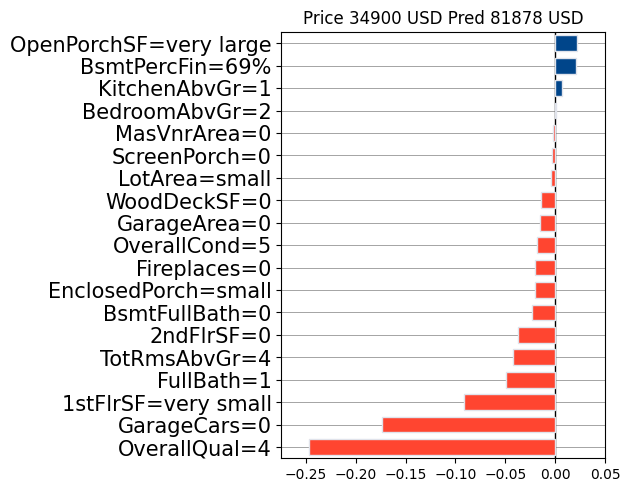

##### Instance 916 #####


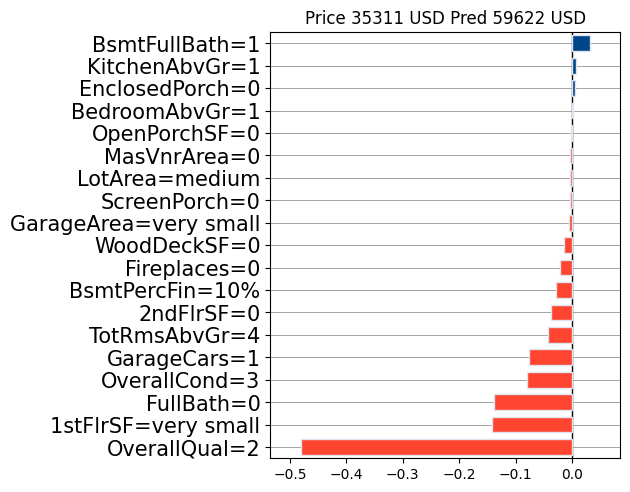

##### Instance 968 #####


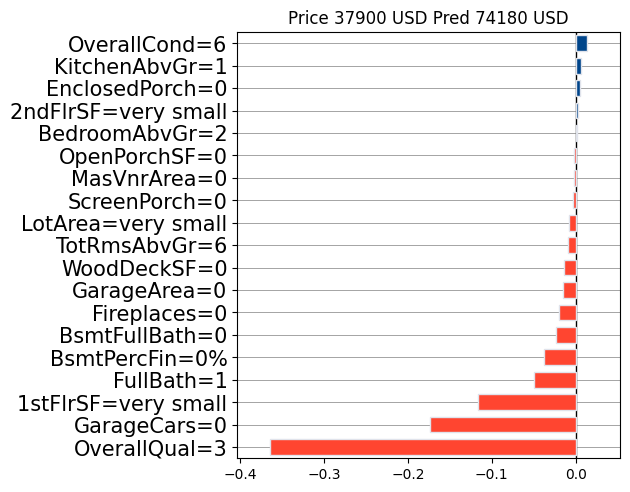

##### Instance 533 #####


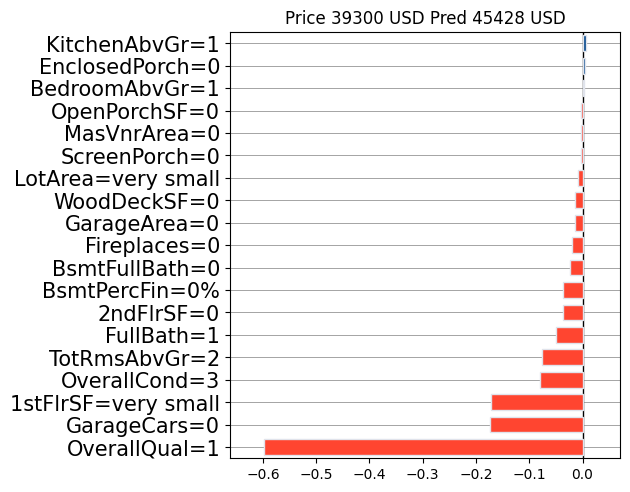

##### Instance 30 #####


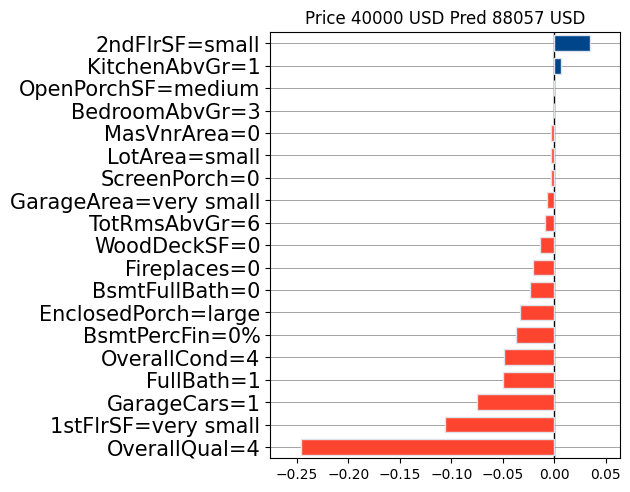

##### Instance 803 #####


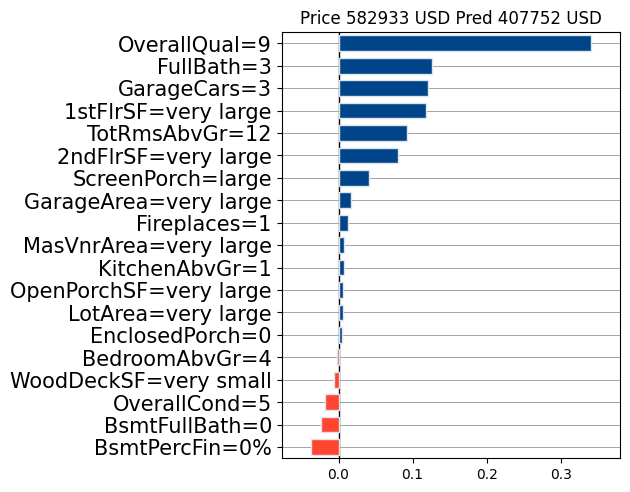

##### Instance 898 #####


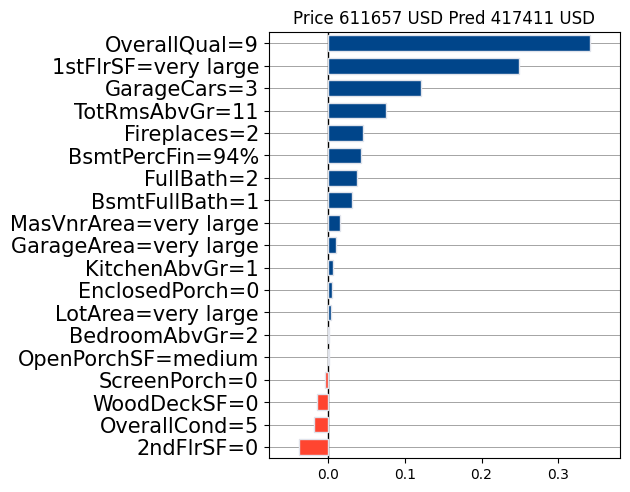

##### Instance 1169 #####


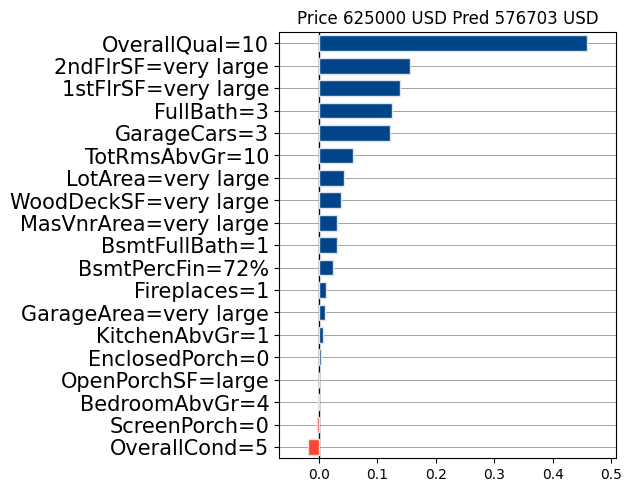

##### Instance 1182 #####


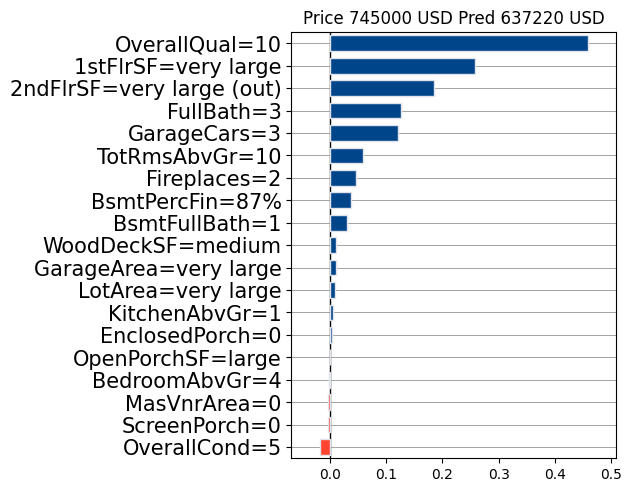

##### Instance 691 #####


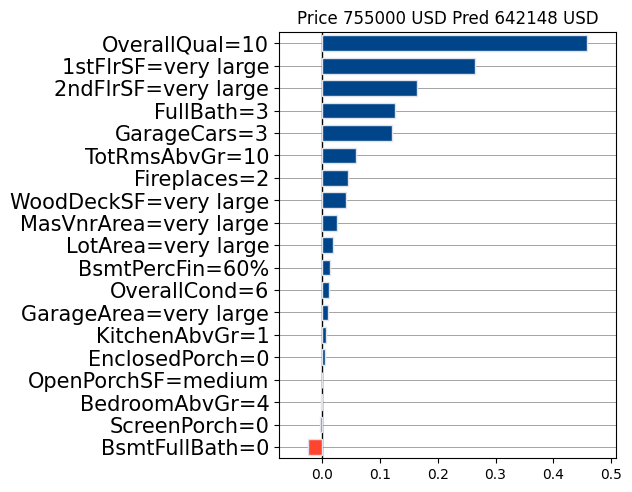

In [10]:
from pyfd.plots import bar

# Local Feature Attributions of top-5 houses with high/low prices
sorted_price_idx = np.argsort(y)
idxs_to_explain = np.concatenate((sorted_price_idx[:5], sorted_price_idx[-5:]))
for idx in idxs_to_explain:
    print(f"##### Instance {idx} #####")
    # Choose the instance
    x_explain = X[[idx]]
    x_map = features.print_value(x_explain.ravel())

    # Predictions and explanation
    pred = np.exp(model.predict(x_explain))
    bar(decomposition_as_array[idx], x_map)
    plt.title(f"Price {np.exp(y[idx]):.0f} USD Pred {pred[0]:.0f} USD")
    plt.show()

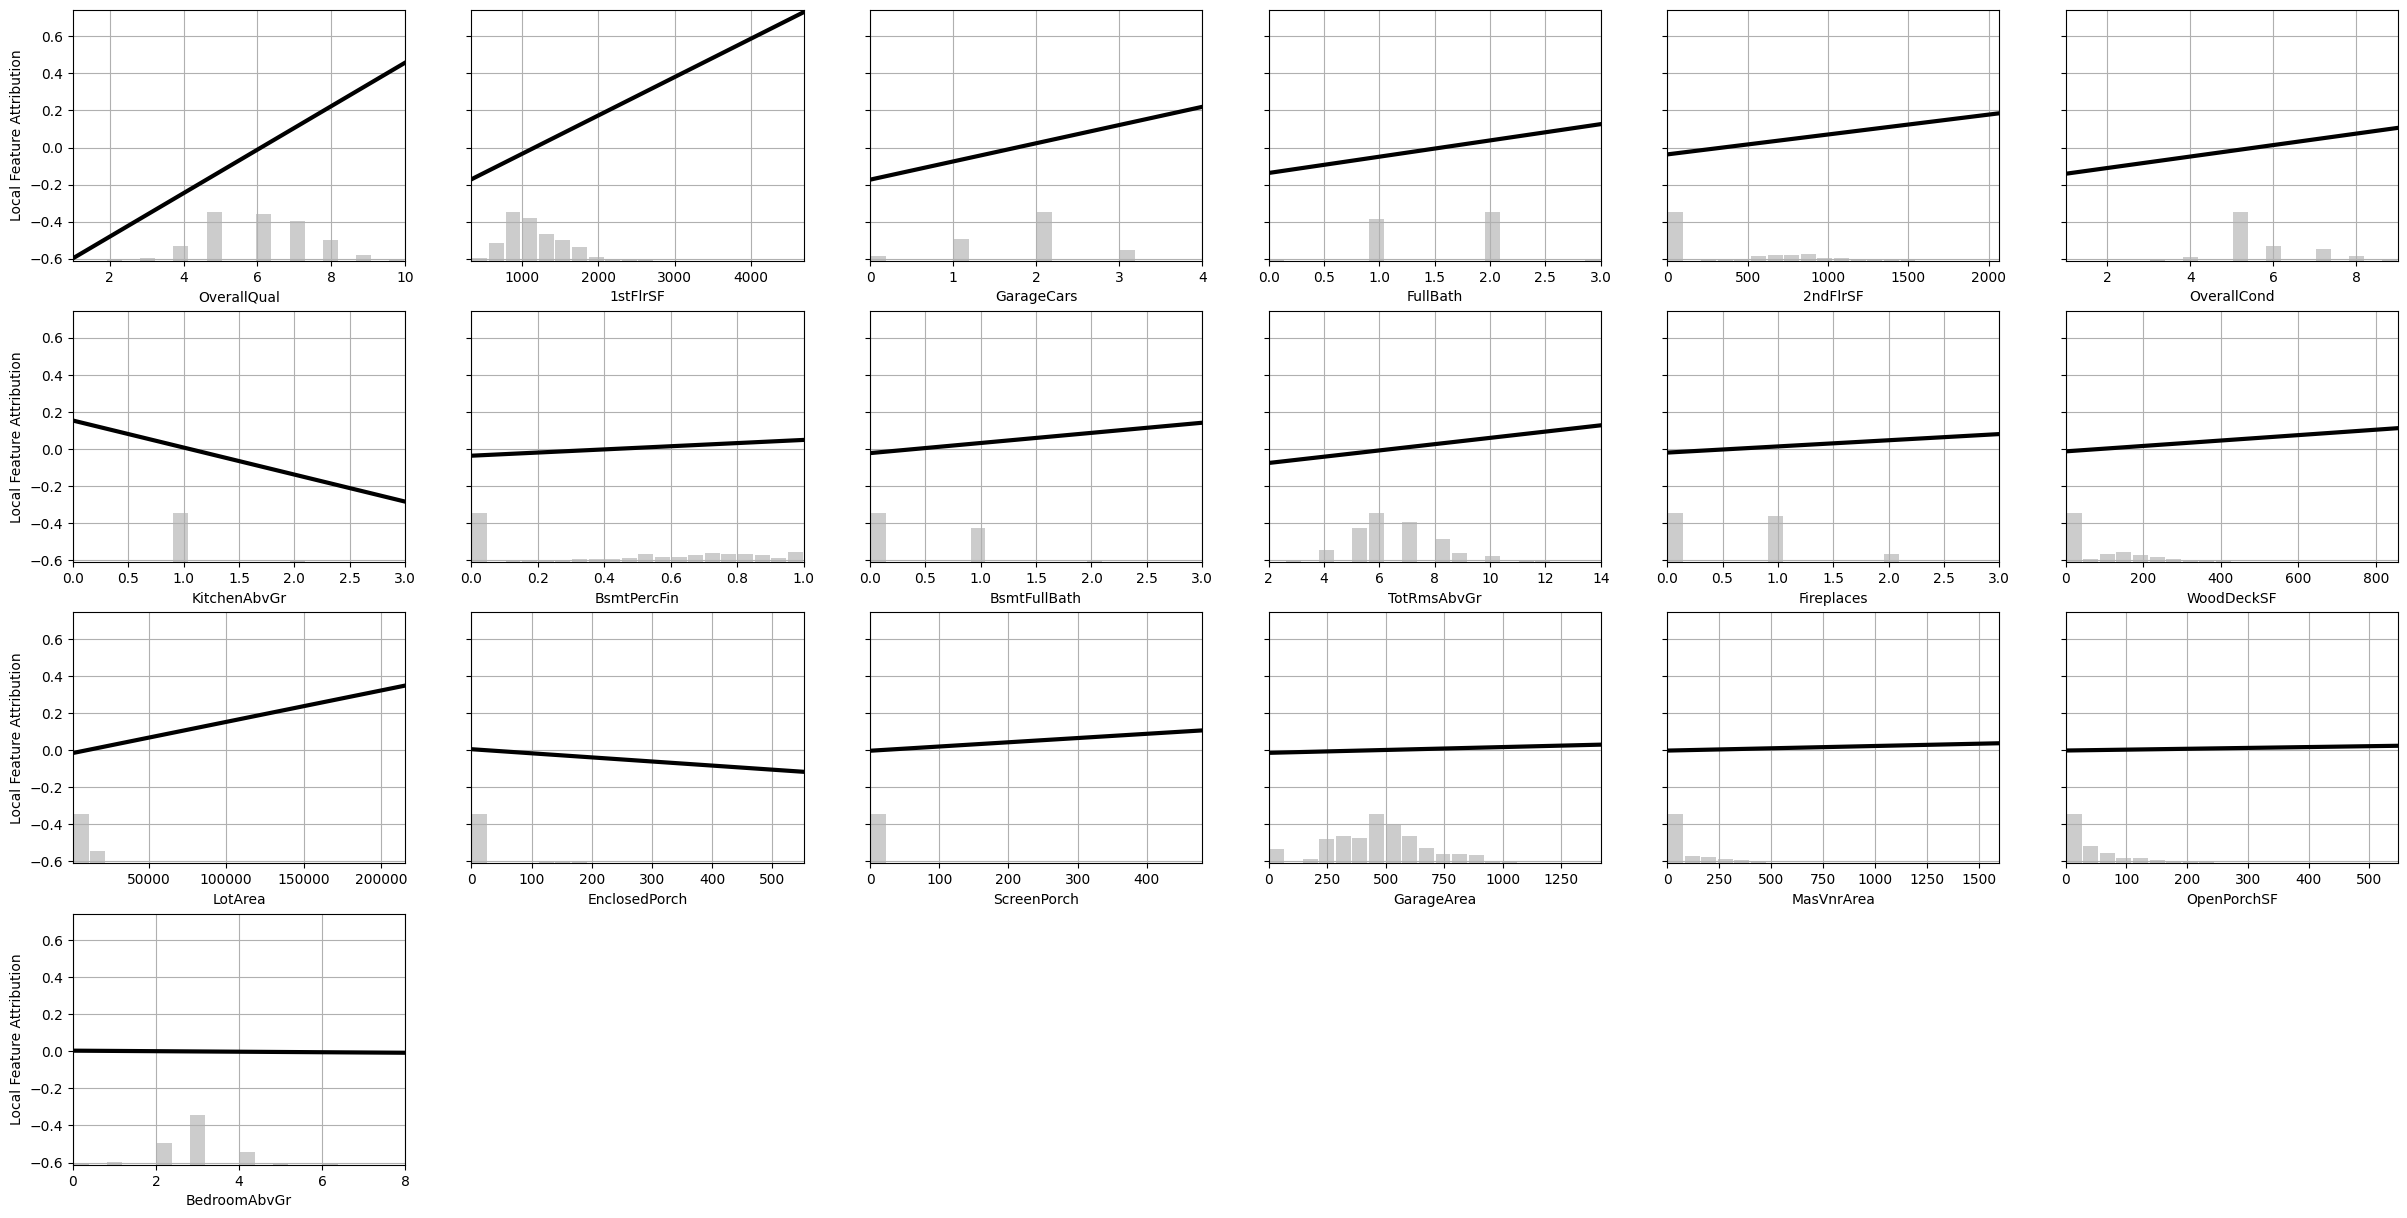

In [12]:
from pyfd.plots import partial_dependence_plot

# Plot the attribution as a function of x_i
partial_dependence_plot(decomposition, foreground, features, plot_hist=True, n_cols=6, figsize=(30, 15))

We can also compute global feature importance for linear models by averaging the squared amplitude of the local feature importance

$$ \text{Global Importance of feature $i$} := \sqrt{\mathbb{E}_{x\sim\mathcal{B}}[ (\text{Local Importance of $x_i$})^2]}
= |\omega_i| \,\,\text{Std}_{x\sim\mathcal{B}}[x_i].$$

When input features are standardized to have unit standard deviation, this global importance score is simply the magnitude of the $\omega_i$ coefficient.

### Global Feature Importance

Text(0.5, 23.52222222222222, 'Global Feature Importance')

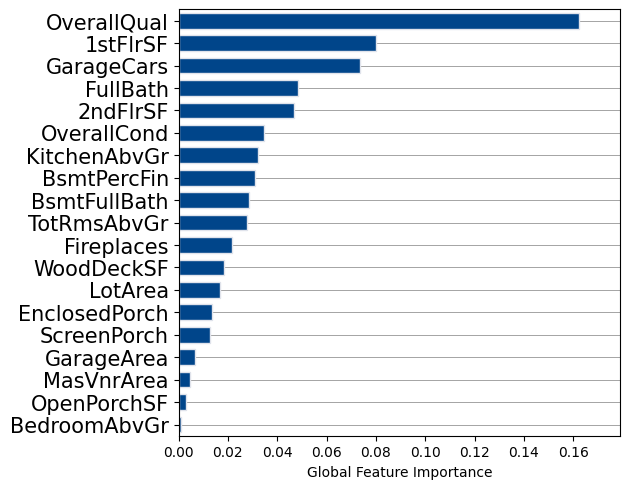

In [13]:
# Global Feature Importance
Importance = np.sqrt(np.mean(decomposition_as_array**2, axis=0))
bar(Importance, features.names())
plt.xlabel("Global Feature Importance")